In [53]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import tensorflow as tf

In [54]:
data = pd.read_csv('/kaggle/input/weather-prediction/seattle-weather.csv')
display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


None

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [55]:
import matplotlib.pyplot as plt

In [56]:
import matplotlib.dates as mdates

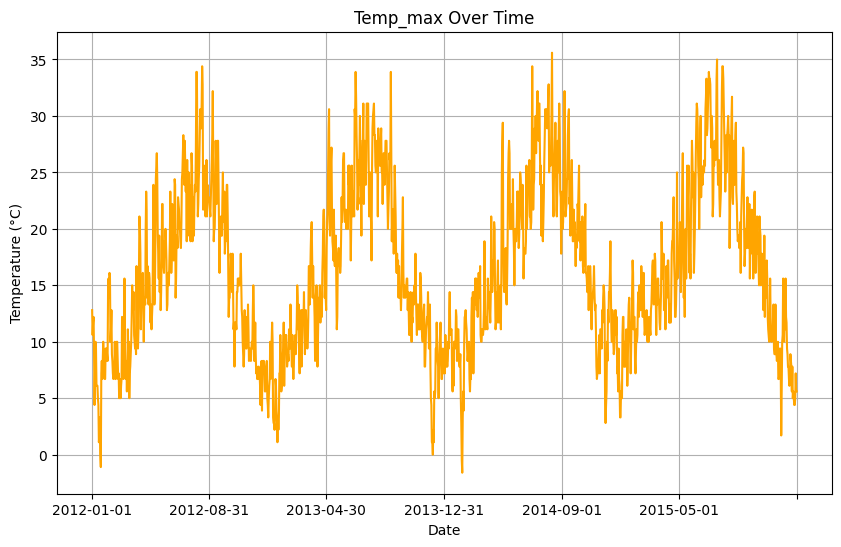

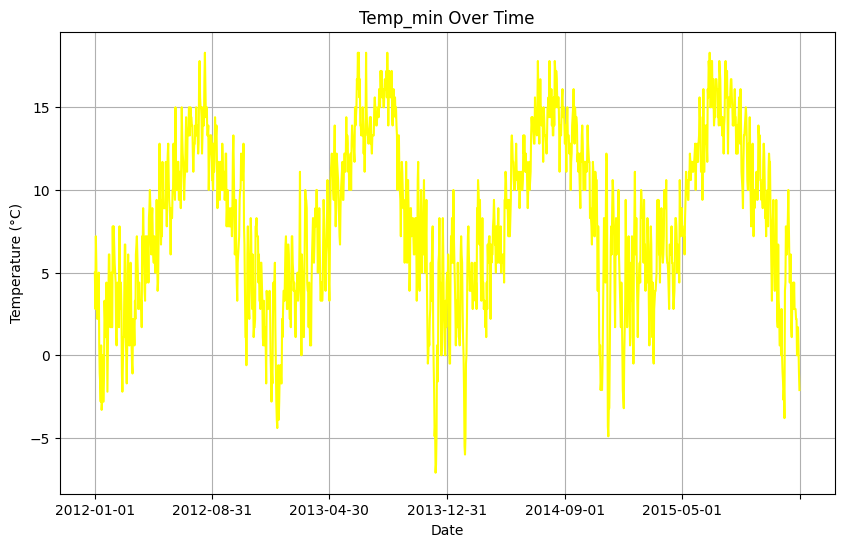

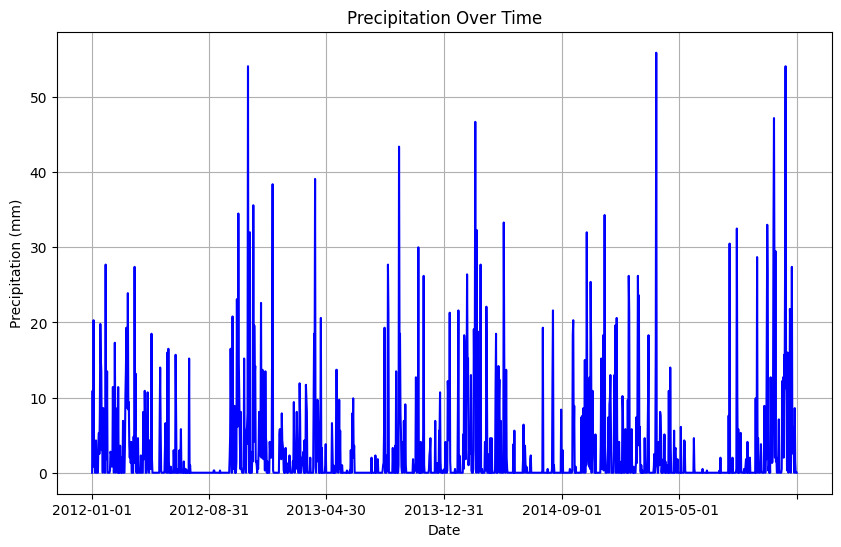

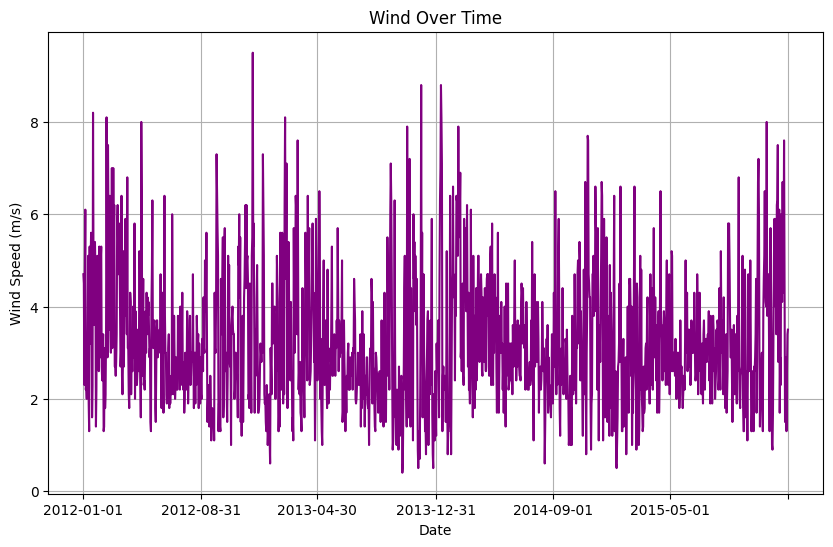

In [57]:
def plot_weather_parameter(data, parameter, ylabel, color):
    plt.figure(figsize=(10, 6))
    plt.plot(data['date'], data[parameter], color=color)
    plt.title(f'{parameter.capitalize()} Over Time')
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=8))
   # plt.tight_layout()
    plt.show()

plot_weather_parameter(data, 'temp_max', 'Temperature (°C)', 'orange')
plot_weather_parameter(data, 'temp_min', 'Temperature (°C)', 'yellow')
plot_weather_parameter(data, 'precipitation', 'Precipitation (mm)', 'blue')
plot_weather_parameter(data, 'wind', 'Wind Speed (m/s)', 'purple')

In [58]:
data = data.drop(columns = ['date'])

In [59]:
data = pd.get_dummies(data, columns=['weather'])
data.head()

,precipitation,temp_max,temp_min,wind,weather_drizzle,weather_fog,weather_rain,weather_snow,weather_sun
0,0.0,12.8,5.0,4.7,True,False,False,False,False
1,10.9,10.6,2.8,4.5,False,False,True,False,False
2,0.8,11.7,7.2,2.3,False,False,True,False,False
3,20.3,12.2,5.6,4.7,False,False,True,False,False
4,1.3,8.9,2.8,6.1,False,False,True,False,False


In [60]:
scaler = StandardScaler()
data[['precipitation', 'wind']] = scaler.fit_transform(data[['precipitation', 'wind']])

In [61]:
data.describe()

,precipitation,temp_max,temp_min,wind
count,1.461000e+03,1461.000000,1461.000000,1.461000e+03
mean,2.674870e-17,16.439083,8.234771,-8.754120e-17
std,1.000342e+00,7.349758,5.023004,1.000342e+00
min,-4.536499e-01,-1.600000,-7.100000,-1.976672e+00
25%,-4.536499e-01,10.600000,4.400000,-7.243529e-01
50%,-4.536499e-01,15.600000,8.300000,-1.677664e-01
75%,-3.435685e-02,22.200000,12.200000,5.279666e-01
max,7.917235e+00,35.600000,18.300000,4.354498e+00


In [62]:
sequence_length = 7
X = np.array([data.iloc[i:i+sequence_length].drop('temp_max', axis=1).values for i in range(len(data) - sequence_length)])
y = np.array([data.iloc[i:i+sequence_length]['temp_max'] for i in range(len(data) - sequence_length)])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [65]:
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(units=50, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(units=50)(x)
    x = Dropout(0.2)(x)
    outputs = Dense(units=1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [66]:
input_shape = (X_train.shape[1], X_train.shape[2])

model = build_model(input_shape)

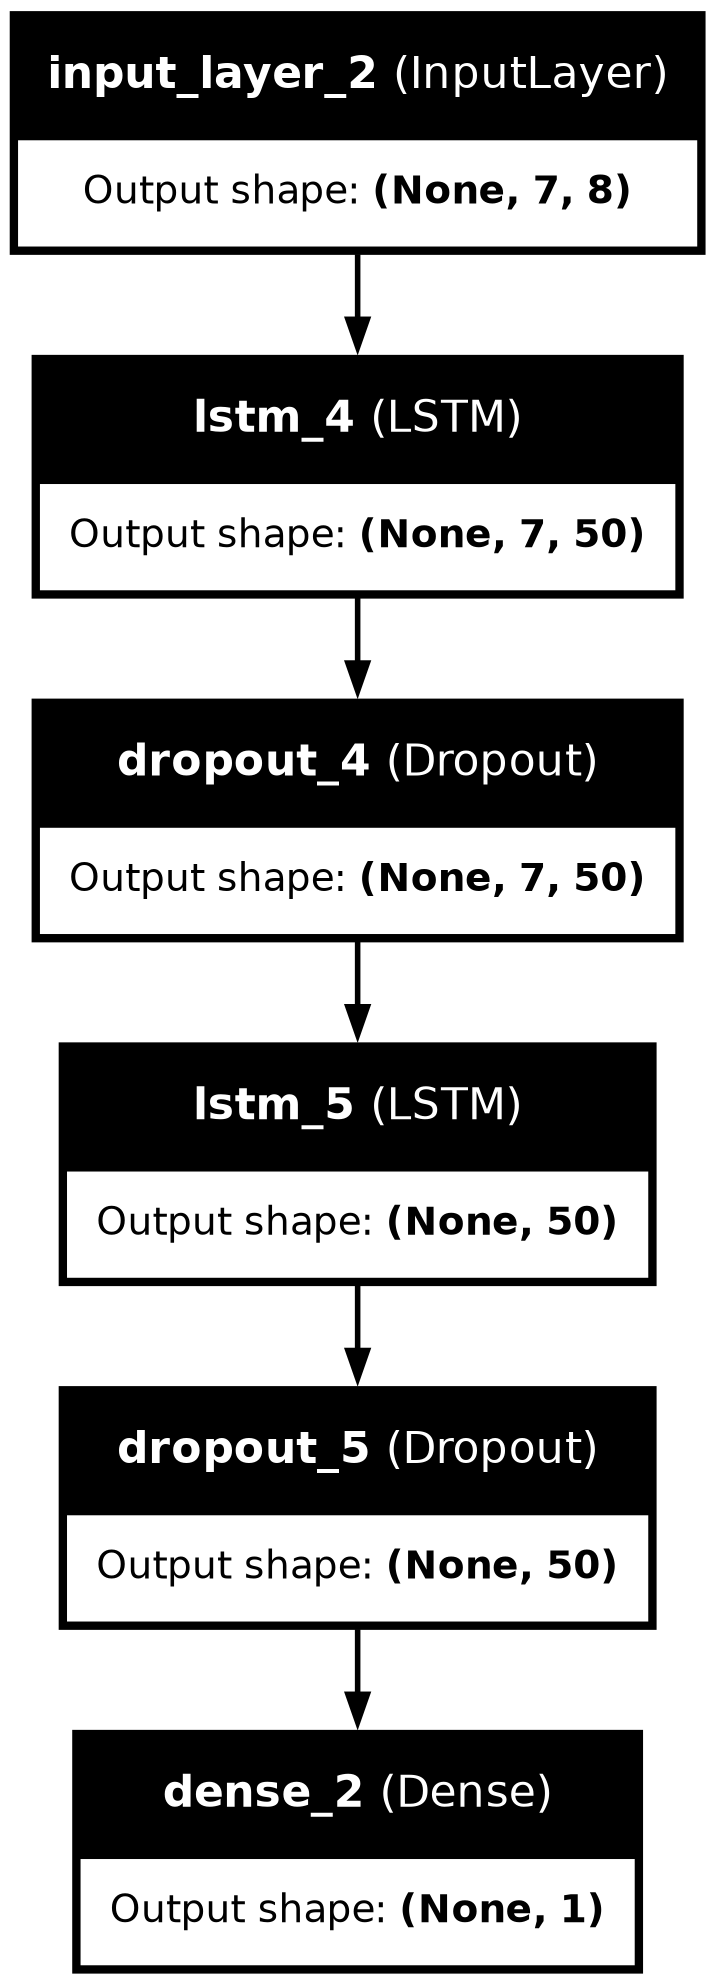

In [67]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [68]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [69]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [70]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
history_callback = LossHistory()

In [71]:
history = model.fit(X_train, y_train, epochs=35, batch_size=32, validation_split=0.1, callbacks=[history_callback])

Epoch 1/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 279.9524 - val_loss: 108.0182
Epoch 2/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 114.0828 - val_loss: 62.5824
Epoch 3/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 78.7192 - val_loss: 51.7071
Epoch 4/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 62.4245 - val_loss: 45.8298
Epoch 5/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 54.4679 - val_loss: 33.3477
Epoch 6/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 41.4693 - val_loss: 27.0584
Epoch 7/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 34.7789 - val_loss: 21.9383
Epoch 8/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.6894 - val_loss: 18.9383
Epoch 9/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 26.4285 - val_loss: 15.8391
Epoch 10/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.4807 - val_loss: 13.9015
Epoch 11/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.1544 - val_loss: 12.7295
Epoch 12/35
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

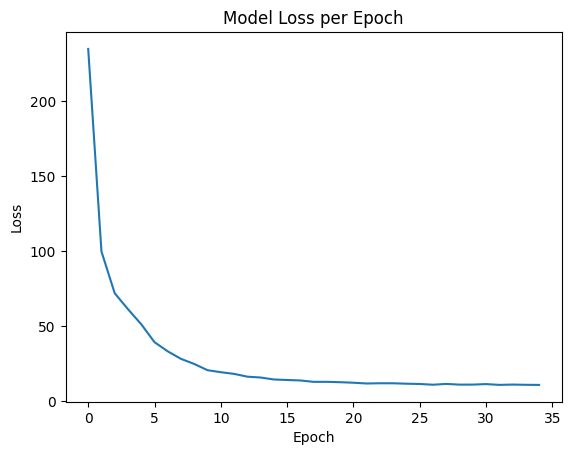

In [72]:
plt.plot(history_callback.losses)
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [73]:
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9198 
Test Loss: 8.507620811462402
